# 0.1 Task (LeakyReLU)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ssl
import copy
from sklearn import metrics
import numpy as np
import math
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


True
cuda:0


In [2]:
# Define the mini-batch size
batch_size = 5000

# Download the dataset and create the dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5,  0.5,  0.5],std=[0.5, 0.5, 0.5])
    ])
#Load all train:
cifar_full = datasets.CIFAR10("./", train=True, download=True, transform=transform)

#Split training, validation
cifar_train, cifar_validation = torch.utils.data.random_split(cifar_full, [0.8, 0.2])
train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False)
batch_size_validation = len(cifar_validation)
validation_loader = DataLoader(cifar_validation, batch_size=batch_size_validation, shuffle=False)

#Load test:
cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=transform)
batch_size_test = len(cifar_test)
test_loader = DataLoader(cifar_test, batch_size=batch_size_test, shuffle=False)

print('Length training set: ', len(cifar_train))
print('Length validation set: ', len(cifar_validation))
print('Length test set: ', len(cifar_test))

def plot_image(image):
    image = np.transpose(image,[1,2,0])
    #print(image.shape)
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.show()
    
def accuracy_func(loader, model):
    total = 0
    correct = 0
    for bacth_nr, (images, labels) in enumerate(loader):
        images,labels = images.to(device), labels.to(device)
        predictions = model.forward(images)
        predictions = torch.argmax(predictions, dim=-1)
        for i in range(len(images)):
            if labels[i] == predictions[i]:
                correct += 1
            total += 1
    accuracy = correct/total
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Length training set:  40000
Length validation set:  10000
Length test set:  10000


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 10)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
    def forward(self, x):
        # Implement the forward function in the network
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,16*7*7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs):
    min_validation_loss = 10000    
    # Store training and validation loss
    training_loss, validation_loss = [], []
    for i in range(epochs):
        
        epoch_validation_loss = 0
        for batch_nr, (images, labels) in enumerate(validation_loader):
        
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)
        
            prediction = model.forward(images)
            
            loss = criterion(prediction, labels)

            epoch_validation_loss += loss.item()
            
        validation_loss.append(epoch_validation_loss/(batch_nr+1))

        if validation_loss[i] < min_validation_loss:
            min_validation_loss = validation_loss[i]
            optModel = copy.deepcopy(model)
            minValLossEpoch = i
            #print(i)

        k = 0
        epoch_training_loss = 0
        for batch_nr, (images, labels) in enumerate(train_loader):
            k += 1
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)

            prediction = model.forward(images)

            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            epoch_training_loss += loss.item()
            
        training_loss.append(epoch_training_loss/k)
        
        if i % 10 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            
    plt.figure(figsize=(6,5))
    plt.plot(range(1,epochs+1), training_loss, 'r', label='Training loss',)
    plt.plot(range(1,epochs+1), validation_loss, 'b', label='Validation loss')
    plt.plot((minValLossEpoch+1,minValLossEpoch+1),(0,max(training_loss+validation_loss)),'k-',label='Best model') 
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.grid()
    #plt.ylim((0, 1)) 
    plt.show()
    return optModel


In [4]:
#Hyperparameters
epochs = 100
SHUFFLE = False
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0

## Optimizer: SGD

Epoch 0, training loss: 2.307154566049576, validation loss: 2.30704402923584
Epoch 10, training loss: 2.307038724422455, validation loss: 2.3069334030151367
Epoch 20, training loss: 2.306923061609268, validation loss: 2.3068225383758545
Epoch 30, training loss: 2.3068075478076935, validation loss: 2.3067121505737305
Epoch 40, training loss: 2.3066920042037964, validation loss: 2.3066020011901855
Epoch 50, training loss: 2.306576669216156, validation loss: 2.3064918518066406
Epoch 60, training loss: 2.306461274623871, validation loss: 2.3063814640045166
Epoch 70, training loss: 2.306345909833908, validation loss: 2.3062710762023926
Epoch 80, training loss: 2.3062305748462677, validation loss: 2.3061609268188477
Epoch 90, training loss: 2.3061152696609497, validation loss: 2.3060505390167236


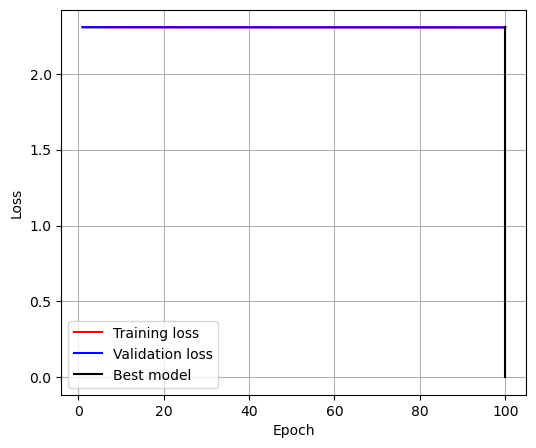

In [5]:
#Optimizer: SGD

# Load our network
model = Net().to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = optim.SGD(model.parameters(), LEARNING_RATE, weight_decay = WEIGHT_DECAY) #Weight_decay motsvarar lambda i L2norm-regularization

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs)

# Test the model
tested_model = copy.deepcopy(trained_model)

In [6]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 9.3525%
Accuracy, dataset_validation: 9.51%
Accuracy, dataset_test: 9.58%


## Optimizer: Adam

Epoch 0, training loss: 2.2994920313358307, validation loss: 2.3026981353759766
Epoch 10, training loss: 2.195729583501816, validation loss: 2.2045130729675293
Epoch 20, training loss: 2.0246100425720215, validation loss: 2.034738540649414
Epoch 30, training loss: 1.920561671257019, validation loss: 1.9299589395523071
Epoch 40, training loss: 1.8401656299829483, validation loss: 1.849916934967041
Epoch 50, training loss: 1.769207388162613, validation loss: 1.7787686586380005
Epoch 60, training loss: 1.713090643286705, validation loss: 1.7220991849899292
Epoch 70, training loss: 1.6711579114198685, validation loss: 1.6806827783584595
Epoch 80, training loss: 1.637223407626152, validation loss: 1.648067593574524
Epoch 90, training loss: 1.6074880957603455, validation loss: 1.6202890872955322


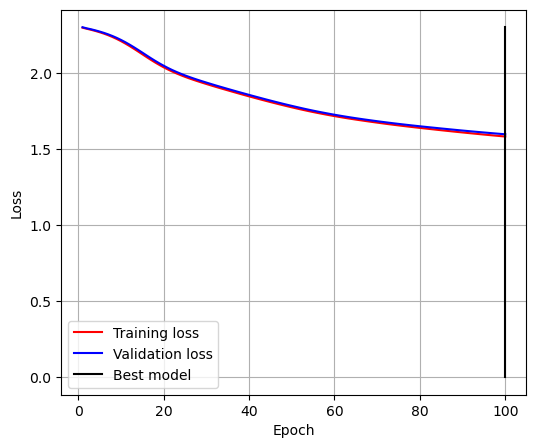

In [7]:
#Repeat for optimizer: Adam

# Load our network
model = Net().to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = optim.Adam(model.parameters(), LEARNING_RATE, weight_decay = WEIGHT_DECAY) #Weight_decay motsvarar lambda i L2norm-regularization

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs)

# Test the model
tested_model = copy.deepcopy(trained_model)

In [8]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 44.335%
Accuracy, dataset_validation: 43.43%
Accuracy, dataset_test: 44.13%


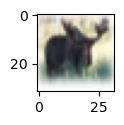

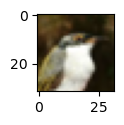

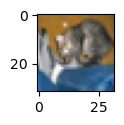

In [19]:
images,labels = next(iter(train_loader))
i = 0
plot_image(images[i])
#print(images[i])
#print(labels[i])
#print(images[i].shape)


images,labels = next(iter(validation_loader))
plot_image(images[0])
#print(images[0].shape)

images,labels = next(iter(test_loader))
plot_image(images[0])
